In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def init_weights(m):
  if  type(m) == nn.Conv2d:
    torch.nn.init.xavier_uniform(m.weight)
    #torch.nn.init.xavier_uniform(m.bias)


In [2]:
# Following Udacity's Computer Vision ND project.

import torch
import torch.nn as nn
import torch.nn.functional as F
from importlib import reload
## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/FaceDetection/')  # Only needed the first time.
#print(sys.path)
import models

reload(models)
from models import Net
net = Net()

num_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("number parameters ",num_param)
#print(net)
#net.apply(init_weights)

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("gpu available")
else:
  device = torch.device("cpu")
net.to(device)

number parameters  40417816
gpu available


Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=100352, out_features=400, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (linear2): Linear(in_features=400, out_features=136, bias=True)
)

In [3]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2020-01-06 01:15:40--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  65.3MB/s    in 5.0s    

2020-01-06 01:15:46 (64.1 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_

In [4]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/content/drive/My Drive/FaceDetection/')
print(sys.path)
#!ls /content/drive/My\ Drive/FaceDetection
import data_load

['', '/content/drive/My Drive/FaceDetection/', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
import data_load
reload(data_load)

from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, Noise


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
#data_transform = transforms.Compose([Rescale((224,224)),transforms.RandomGrayscale(p=0.1),Normalize(),ToTensor()])
data_transform = transforms.Compose([Rescale((224,224)),Normalize(),ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


In [0]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [0]:
# test the model on a batch of train images

def train_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(train_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


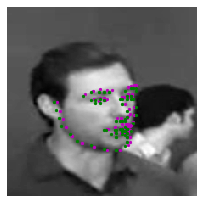

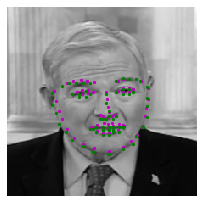

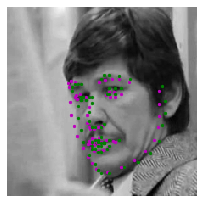

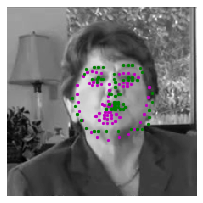

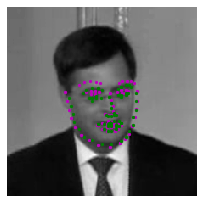

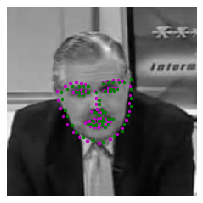

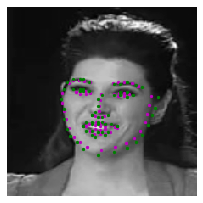

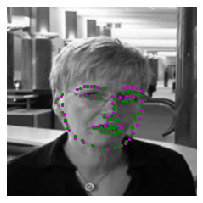

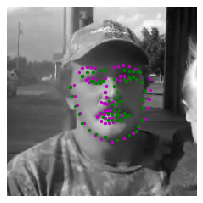

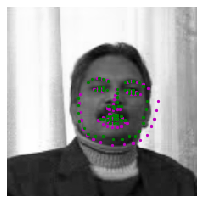

In [17]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(40,20))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        #print(predicted_key_pts)
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
            #print(ground_truth_pts.shape)
            #print(predicted_key_pts)
        
        #for p,g in zip(predicted_key_pts,ground_truth_pts):
        ground_truth_pts = ground_truth_pts.cpu().numpy()
        diff = predicted_key_pts - ground_truth_pts
        #print("diff shape", diff)
        mse = np.linalg.norm(diff)
        #print("loss ",mse)

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [0]:
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

def train_net(n_epochs,device=device):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
            #key_pts = key_pts.to(device)
            #images = images.to(device)
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 20 == 19:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 40 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch

train_net(n_epochs,device)

/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 20, Avg. Loss: 0.5683214269578457
Epoch: 1, Batch: 40, Avg. Loss: 0.18671397492289543
Epoch: 1, Batch: 60, Avg. Loss: 0.15255926549434662
Epoch: 1, Batch: 80, Avg. Loss: 0.14503137171268463
Epoch: 1, Batch: 100, Avg. Loss: 0.1354186873883009
Epoch: 1, Batch: 120, Avg. Loss: 0.12688765563070775
Epoch: 1, Batch: 140, Avg. Loss: 0.1347507979720831
Epoch: 1, Batch: 160, Avg. Loss: 0.1519968580454588
Epoch: 1, Batch: 180, Avg. Loss: 0.13023548312485217
Epoch: 1, Batch: 200, Avg. Loss: 0.12381930351257324
Epoch: 1, Batch: 220, Avg. Loss: 0.13636910803616048
Epoch: 1, Batch: 240, Avg. Loss: 0.14355338290333747
Epoch: 1, Batch: 260, Avg. Loss: 0.12736012525856494
Epoch: 1, Batch: 280, Avg. Loss: 0.12677260860800743
Epoch: 1, Batch: 300, Avg. Loss: 0.1243797305971384
Epoch: 1, Batch: 320, Avg. Loss: 0.12726020254194736
Epoch: 1, Batch: 340, Avg. Loss: 0.12078349217772484


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 20, Avg. Loss: 0.11930067576467991
Epoch: 2, Batch: 40, Avg. Loss: 0.1438429795205593
Epoch: 2, Batch: 60, Avg. Loss: 0.12688028775155544
Epoch: 2, Batch: 80, Avg. Loss: 0.11805303618311883
Epoch: 2, Batch: 100, Avg. Loss: 0.13349796757102012
Epoch: 2, Batch: 120, Avg. Loss: 0.1184792760759592
Epoch: 2, Batch: 140, Avg. Loss: 0.1197563972324133
Epoch: 2, Batch: 160, Avg. Loss: 0.12289240211248398
Epoch: 2, Batch: 180, Avg. Loss: 0.11883843466639518
Epoch: 2, Batch: 200, Avg. Loss: 0.10165983587503433
Epoch: 2, Batch: 220, Avg. Loss: 0.11791205443441868
Epoch: 2, Batch: 240, Avg. Loss: 0.12095014378428459
Epoch: 2, Batch: 260, Avg. Loss: 0.1248587690293789
Epoch: 2, Batch: 280, Avg. Loss: 0.10267097000032663
Epoch: 2, Batch: 300, Avg. Loss: 0.1018804233521223
Epoch: 2, Batch: 320, Avg. Loss: 0.133496418222785
Epoch: 2, Batch: 340, Avg. Loss: 0.1051303893327713


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 20, Avg. Loss: 0.09054209478199482
Epoch: 3, Batch: 40, Avg. Loss: 0.10390888191759587
Epoch: 3, Batch: 60, Avg. Loss: 0.09498608000576496
Epoch: 3, Batch: 80, Avg. Loss: 0.08059615325182676
Epoch: 3, Batch: 100, Avg. Loss: 0.0892096184194088
Epoch: 3, Batch: 120, Avg. Loss: 0.10023090168833733
Epoch: 3, Batch: 140, Avg. Loss: 0.08806845154613256
Epoch: 3, Batch: 160, Avg. Loss: 0.08893692884594202
Epoch: 3, Batch: 180, Avg. Loss: 0.09101056307554245
Epoch: 3, Batch: 200, Avg. Loss: 0.08024360965937376
Epoch: 3, Batch: 220, Avg. Loss: 0.08381078448146581
Epoch: 3, Batch: 240, Avg. Loss: 0.0943271666765213
Epoch: 3, Batch: 260, Avg. Loss: 0.07944901771843434
Epoch: 3, Batch: 280, Avg. Loss: 0.0686382781714201
Epoch: 3, Batch: 300, Avg. Loss: 0.07494153417646884
Epoch: 3, Batch: 320, Avg. Loss: 0.0843195728957653
Epoch: 3, Batch: 340, Avg. Loss: 0.07088918518275023


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 20, Avg. Loss: 0.06989608611911535
Epoch: 4, Batch: 40, Avg. Loss: 0.06957313343882561
Epoch: 4, Batch: 60, Avg. Loss: 0.07207026463001967
Epoch: 4, Batch: 80, Avg. Loss: 0.06391039900481701
Epoch: 4, Batch: 100, Avg. Loss: 0.07219122666865588
Epoch: 4, Batch: 120, Avg. Loss: 0.06426079720258712
Epoch: 4, Batch: 140, Avg. Loss: 0.05976719437167048
Epoch: 4, Batch: 160, Avg. Loss: 0.07002688907086849
Epoch: 4, Batch: 180, Avg. Loss: 0.0640516545623541
Epoch: 4, Batch: 200, Avg. Loss: 0.07060900200158357
Epoch: 4, Batch: 220, Avg. Loss: 0.0534185872413218
Epoch: 4, Batch: 240, Avg. Loss: 0.060059677623212335
Epoch: 4, Batch: 260, Avg. Loss: 0.06108106607571244
Epoch: 4, Batch: 280, Avg. Loss: 0.06017164755612612
Epoch: 4, Batch: 300, Avg. Loss: 0.052067235205322505
Epoch: 4, Batch: 320, Avg. Loss: 0.06779630985110999
Epoch: 4, Batch: 340, Avg. Loss: 0.05592459514737129


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 20, Avg. Loss: 0.056817459873855114
Epoch: 5, Batch: 40, Avg. Loss: 0.04695062516257167
Epoch: 5, Batch: 60, Avg. Loss: 0.04908114252611995
Epoch: 5, Batch: 80, Avg. Loss: 0.049027367401868104
Epoch: 5, Batch: 100, Avg. Loss: 0.055816832557320596
Epoch: 5, Batch: 120, Avg. Loss: 0.04501519585028291
Epoch: 5, Batch: 140, Avg. Loss: 0.04917339654639363
Epoch: 5, Batch: 160, Avg. Loss: 0.04954902250319719
Epoch: 5, Batch: 180, Avg. Loss: 0.051179753802716735
Epoch: 5, Batch: 200, Avg. Loss: 0.046574358455836774
Epoch: 5, Batch: 220, Avg. Loss: 0.056730594299733636
Epoch: 5, Batch: 240, Avg. Loss: 0.04418373350054026
Epoch: 5, Batch: 260, Avg. Loss: 0.0531420080922544
Epoch: 5, Batch: 280, Avg. Loss: 0.0495897720567882
Epoch: 5, Batch: 300, Avg. Loss: 0.045350298285484314
Epoch: 5, Batch: 320, Avg. Loss: 0.05352591359987855
Epoch: 5, Batch: 340, Avg. Loss: 0.04780022883787751


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 20, Avg. Loss: 0.034258593991398814
Epoch: 6, Batch: 40, Avg. Loss: 0.04011566918343305
Epoch: 6, Batch: 60, Avg. Loss: 0.042764045670628546
Epoch: 6, Batch: 80, Avg. Loss: 0.04168799705803394
Epoch: 6, Batch: 100, Avg. Loss: 0.03855170384049415
Epoch: 6, Batch: 120, Avg. Loss: 0.03649545144289732
Epoch: 6, Batch: 140, Avg. Loss: 0.04082398861646652
Epoch: 6, Batch: 160, Avg. Loss: 0.04073453741148114
Epoch: 6, Batch: 180, Avg. Loss: 0.04283567285165191
Epoch: 6, Batch: 200, Avg. Loss: 0.04580909488722682
Epoch: 6, Batch: 220, Avg. Loss: 0.040668063517659905
Epoch: 6, Batch: 240, Avg. Loss: 0.04205346526578069
Epoch: 6, Batch: 260, Avg. Loss: 0.038512897491455075
Epoch: 6, Batch: 280, Avg. Loss: 0.04395316215232015
Epoch: 6, Batch: 300, Avg. Loss: 0.03744434891268611
Epoch: 6, Batch: 320, Avg. Loss: 0.03349493565037846
Epoch: 6, Batch: 340, Avg. Loss: 0.03942956672981381


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 20, Avg. Loss: 0.034292940702289346
Epoch: 7, Batch: 40, Avg. Loss: 0.03148826882243157
Epoch: 7, Batch: 60, Avg. Loss: 0.03238403648138046
Epoch: 7, Batch: 80, Avg. Loss: 0.029780817590653895
Epoch: 7, Batch: 100, Avg. Loss: 0.029040439426898955
Epoch: 7, Batch: 120, Avg. Loss: 0.029355425015091897
Epoch: 7, Batch: 140, Avg. Loss: 0.03624406745657325
Epoch: 7, Batch: 160, Avg. Loss: 0.036692124977707866
Epoch: 7, Batch: 180, Avg. Loss: 0.03088476825505495
Epoch: 7, Batch: 200, Avg. Loss: 0.03591363336890936
Epoch: 7, Batch: 220, Avg. Loss: 0.029691957263275982
Epoch: 7, Batch: 240, Avg. Loss: 0.032421285193413495
Epoch: 7, Batch: 260, Avg. Loss: 0.03723021666519344
Epoch: 7, Batch: 280, Avg. Loss: 0.03764124801382422
Epoch: 7, Batch: 300, Avg. Loss: 0.03087674155831337
Epoch: 7, Batch: 320, Avg. Loss: 0.030386582110077144
Epoch: 7, Batch: 340, Avg. Loss: 0.03132138466462493


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 20, Avg. Loss: 0.027115452010184525
Epoch: 8, Batch: 40, Avg. Loss: 0.02936710212379694
Epoch: 8, Batch: 60, Avg. Loss: 0.02480051154270768
Epoch: 8, Batch: 80, Avg. Loss: 0.029195417044684292
Epoch: 8, Batch: 100, Avg. Loss: 0.028583621187135578
Epoch: 8, Batch: 120, Avg. Loss: 0.02465281169861555
Epoch: 8, Batch: 140, Avg. Loss: 0.028059315774589776
Epoch: 8, Batch: 160, Avg. Loss: 0.024888867512345314
Epoch: 8, Batch: 180, Avg. Loss: 0.02551970910280943
Epoch: 8, Batch: 200, Avg. Loss: 0.0230548941064626
Epoch: 8, Batch: 220, Avg. Loss: 0.027458641771227123
Epoch: 8, Batch: 240, Avg. Loss: 0.024879857059568168
Epoch: 8, Batch: 260, Avg. Loss: 0.02973624523729086
Epoch: 8, Batch: 280, Avg. Loss: 0.027687224000692366
Epoch: 8, Batch: 300, Avg. Loss: 0.025113274715840815
Epoch: 8, Batch: 320, Avg. Loss: 0.03221394661813974
Epoch: 8, Batch: 340, Avg. Loss: 0.0267640576697886


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 20, Avg. Loss: 0.02287578582763672
Epoch: 9, Batch: 40, Avg. Loss: 0.02298022769391537
Epoch: 9, Batch: 60, Avg. Loss: 0.023607613099738956
Epoch: 9, Batch: 80, Avg. Loss: 0.025936959218233822
Epoch: 9, Batch: 100, Avg. Loss: 0.02355323885567486
Epoch: 9, Batch: 120, Avg. Loss: 0.02314287596382201
Epoch: 9, Batch: 140, Avg. Loss: 0.022389155672863127
Epoch: 9, Batch: 160, Avg. Loss: 0.023640314070507883
Epoch: 9, Batch: 180, Avg. Loss: 0.020897575793787836
Epoch: 9, Batch: 200, Avg. Loss: 0.02201665686443448
Epoch: 9, Batch: 220, Avg. Loss: 0.025260547269135715
Epoch: 9, Batch: 240, Avg. Loss: 0.024546324368566276
Epoch: 9, Batch: 260, Avg. Loss: 0.02457573004066944
Epoch: 9, Batch: 280, Avg. Loss: 0.028634486254304647
Epoch: 9, Batch: 300, Avg. Loss: 0.025094181951135396
Epoch: 9, Batch: 320, Avg. Loss: 0.022980416752398015
Epoch: 9, Batch: 340, Avg. Loss: 0.022156101232394577


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 20, Avg. Loss: 0.023494360316544772
Epoch: 10, Batch: 40, Avg. Loss: 0.0197647247929126
Epoch: 10, Batch: 60, Avg. Loss: 0.022658975049853324
Epoch: 10, Batch: 80, Avg. Loss: 0.020051775313913823
Epoch: 10, Batch: 100, Avg. Loss: 0.021427203621715307
Epoch: 10, Batch: 120, Avg. Loss: 0.01905759023502469
Epoch: 10, Batch: 140, Avg. Loss: 0.020069768419489264
Epoch: 10, Batch: 160, Avg. Loss: 0.019681381387636067
Epoch: 10, Batch: 180, Avg. Loss: 0.019401424936950205
Epoch: 10, Batch: 200, Avg. Loss: 0.019802247220650316
Epoch: 10, Batch: 220, Avg. Loss: 0.023080564429983498
Epoch: 10, Batch: 240, Avg. Loss: 0.020259396359324455
Epoch: 10, Batch: 260, Avg. Loss: 0.019436529139056802
Epoch: 10, Batch: 280, Avg. Loss: 0.020510860485956073
Epoch: 10, Batch: 300, Avg. Loss: 0.02156168073415756
Epoch: 10, Batch: 320, Avg. Loss: 0.018829235527664422
Epoch: 10, Batch: 340, Avg. Loss: 0.0193535887170583


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 20, Avg. Loss: 0.022484310576692222
Epoch: 11, Batch: 40, Avg. Loss: 0.019843911891803144
Epoch: 11, Batch: 60, Avg. Loss: 0.01784530784934759
Epoch: 11, Batch: 80, Avg. Loss: 0.020032036257907747
Epoch: 11, Batch: 100, Avg. Loss: 0.017591935535892844
Epoch: 11, Batch: 120, Avg. Loss: 0.016665904549881816
Epoch: 11, Batch: 140, Avg. Loss: 0.01736948490142822
Epoch: 11, Batch: 160, Avg. Loss: 0.01864537918008864
Epoch: 11, Batch: 180, Avg. Loss: 0.018317841039970518
Epoch: 11, Batch: 200, Avg. Loss: 0.020186564745381476
Epoch: 11, Batch: 220, Avg. Loss: 0.02045918144285679
Epoch: 11, Batch: 240, Avg. Loss: 0.02015726864337921
Epoch: 11, Batch: 260, Avg. Loss: 0.020369947981089355
Epoch: 11, Batch: 280, Avg. Loss: 0.02071648887358606
Epoch: 11, Batch: 300, Avg. Loss: 0.01865190817043185
Epoch: 11, Batch: 320, Avg. Loss: 0.02153783245012164
Epoch: 11, Batch: 340, Avg. Loss: 0.018782426463440062


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 20, Avg. Loss: 0.01736011225730181
Epoch: 12, Batch: 40, Avg. Loss: 0.019578941678628326
Epoch: 12, Batch: 60, Avg. Loss: 0.018141737719997764
Epoch: 12, Batch: 80, Avg. Loss: 0.01878607920370996
Epoch: 12, Batch: 100, Avg. Loss: 0.017113357316702604
Epoch: 12, Batch: 120, Avg. Loss: 0.02010314636863768
Epoch: 12, Batch: 140, Avg. Loss: 0.018461443157866596
Epoch: 12, Batch: 160, Avg. Loss: 0.018618135107681157
Epoch: 12, Batch: 180, Avg. Loss: 0.018541113939136267
Epoch: 12, Batch: 200, Avg. Loss: 0.017462567146867513
Epoch: 12, Batch: 220, Avg. Loss: 0.017523388005793096
Epoch: 12, Batch: 240, Avg. Loss: 0.016240062704309822
Epoch: 12, Batch: 260, Avg. Loss: 0.01775243286974728
Epoch: 12, Batch: 280, Avg. Loss: 0.018074578139930964
Epoch: 12, Batch: 300, Avg. Loss: 0.018380121001973747
Epoch: 12, Batch: 320, Avg. Loss: 0.017711351392790675
Epoch: 12, Batch: 340, Avg. Loss: 0.017159653501585125


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 20, Avg. Loss: 0.01704426994547248
Epoch: 13, Batch: 40, Avg. Loss: 0.015412402665242552
Epoch: 13, Batch: 60, Avg. Loss: 0.016128759179264308
Epoch: 13, Batch: 80, Avg. Loss: 0.01572603196837008
Epoch: 13, Batch: 100, Avg. Loss: 0.018290988821536302
Epoch: 13, Batch: 120, Avg. Loss: 0.014521009242162108
Epoch: 13, Batch: 140, Avg. Loss: 0.015698914416134357
Epoch: 13, Batch: 160, Avg. Loss: 0.015560586843639613
Epoch: 13, Batch: 180, Avg. Loss: 0.016652872040867805
Epoch: 13, Batch: 200, Avg. Loss: 0.018738108174875378
Epoch: 13, Batch: 220, Avg. Loss: 0.016753529896959662
Epoch: 13, Batch: 240, Avg. Loss: 0.01766991545446217
Epoch: 13, Batch: 260, Avg. Loss: 0.016946975002065302
Epoch: 13, Batch: 280, Avg. Loss: 0.016501923371106387
Epoch: 13, Batch: 300, Avg. Loss: 0.017662986228242517
Epoch: 13, Batch: 320, Avg. Loss: 0.017844321206212044
Epoch: 13, Batch: 340, Avg. Loss: 0.015554550662636757


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 20, Avg. Loss: 0.01473832381889224
Epoch: 14, Batch: 40, Avg. Loss: 0.018085322761908173
Epoch: 14, Batch: 60, Avg. Loss: 0.015815810533240438
Epoch: 14, Batch: 80, Avg. Loss: 0.01721189571544528
Epoch: 14, Batch: 100, Avg. Loss: 0.01477175047621131
Epoch: 14, Batch: 120, Avg. Loss: 0.01590595217421651
Epoch: 14, Batch: 140, Avg. Loss: 0.014583138469606637
Epoch: 14, Batch: 160, Avg. Loss: 0.016820335108786822
Epoch: 14, Batch: 180, Avg. Loss: 0.017769221123307942
Epoch: 14, Batch: 200, Avg. Loss: 0.015142041910439729
Epoch: 14, Batch: 220, Avg. Loss: 0.016067690588533877
Epoch: 14, Batch: 240, Avg. Loss: 0.015155595634132624
Epoch: 14, Batch: 260, Avg. Loss: 0.015226709423586726
Epoch: 14, Batch: 280, Avg. Loss: 0.015534011786803604
Epoch: 14, Batch: 300, Avg. Loss: 0.01637777523137629
Epoch: 14, Batch: 320, Avg. Loss: 0.01769249071367085
Epoch: 14, Batch: 340, Avg. Loss: 0.018820315366610885


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 20, Avg. Loss: 0.016360014444217086
Epoch: 15, Batch: 40, Avg. Loss: 0.01543422150425613
Epoch: 15, Batch: 60, Avg. Loss: 0.015155265107750893
Epoch: 15, Batch: 80, Avg. Loss: 0.017726455722004174
Epoch: 15, Batch: 100, Avg. Loss: 0.014790776534937322
Epoch: 15, Batch: 120, Avg. Loss: 0.013633644813671708
Epoch: 15, Batch: 140, Avg. Loss: 0.015793196251615883
Epoch: 15, Batch: 160, Avg. Loss: 0.015573130128905177
Epoch: 15, Batch: 180, Avg. Loss: 0.014117740560323
Epoch: 15, Batch: 200, Avg. Loss: 0.01473243087530136
Epoch: 15, Batch: 220, Avg. Loss: 0.015776281477883458
Epoch: 15, Batch: 240, Avg. Loss: 0.017669962299987674
Epoch: 15, Batch: 260, Avg. Loss: 0.017247794289141895
Epoch: 15, Batch: 280, Avg. Loss: 0.015383004397153854
Epoch: 15, Batch: 300, Avg. Loss: 0.014990792516618967
Epoch: 15, Batch: 320, Avg. Loss: 0.016216631047427654
Epoch: 15, Batch: 340, Avg. Loss: 0.015038217976689338


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 20, Avg. Loss: 0.014512707060202957
Epoch: 16, Batch: 40, Avg. Loss: 0.014843289600685238
Epoch: 16, Batch: 60, Avg. Loss: 0.015941457450389863
Epoch: 16, Batch: 80, Avg. Loss: 0.013990216655656695
Epoch: 16, Batch: 100, Avg. Loss: 0.016120137833058833
Epoch: 16, Batch: 120, Avg. Loss: 0.01653358049225062
Epoch: 16, Batch: 140, Avg. Loss: 0.01594473428558558
Epoch: 16, Batch: 160, Avg. Loss: 0.015039377217181026
Epoch: 16, Batch: 180, Avg. Loss: 0.014586871070787311
Epoch: 16, Batch: 200, Avg. Loss: 0.014633296336978675
Epoch: 16, Batch: 220, Avg. Loss: 0.015534225525334478
Epoch: 16, Batch: 240, Avg. Loss: 0.01291754310950637
Epoch: 16, Batch: 260, Avg. Loss: 0.014259224804118276
Epoch: 16, Batch: 280, Avg. Loss: 0.01570347575470805
Epoch: 16, Batch: 300, Avg. Loss: 0.015234000701457261
Epoch: 16, Batch: 320, Avg. Loss: 0.015151676023378968
Epoch: 16, Batch: 340, Avg. Loss: 0.015356362308375537


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 20, Avg. Loss: 0.015607095090672374
Epoch: 17, Batch: 40, Avg. Loss: 0.014840063592419028
Epoch: 17, Batch: 60, Avg. Loss: 0.012613215297460557
Epoch: 17, Batch: 80, Avg. Loss: 0.013485356420278549
Epoch: 17, Batch: 100, Avg. Loss: 0.01435125358402729
Epoch: 17, Batch: 120, Avg. Loss: 0.014231456583365798
Epoch: 17, Batch: 140, Avg. Loss: 0.013983382983133197
Epoch: 17, Batch: 160, Avg. Loss: 0.0158039023168385
Epoch: 17, Batch: 180, Avg. Loss: 0.01444102767854929
Epoch: 17, Batch: 200, Avg. Loss: 0.013778344681486487
Epoch: 17, Batch: 220, Avg. Loss: 0.014574077073484659
Epoch: 17, Batch: 240, Avg. Loss: 0.013366852048784494
Epoch: 17, Batch: 260, Avg. Loss: 0.014194046799093484
Epoch: 17, Batch: 280, Avg. Loss: 0.012060244334861636
Epoch: 17, Batch: 300, Avg. Loss: 0.013335844269022346
Epoch: 17, Batch: 320, Avg. Loss: 0.01430249228142202
Epoch: 17, Batch: 340, Avg. Loss: 0.014567041769623756


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 20, Avg. Loss: 0.01257474566809833
Epoch: 18, Batch: 40, Avg. Loss: 0.015345717454329133
Epoch: 18, Batch: 60, Avg. Loss: 0.013779037445783616
Epoch: 18, Batch: 80, Avg. Loss: 0.012932616146281361
Epoch: 18, Batch: 100, Avg. Loss: 0.013987571047618986
Epoch: 18, Batch: 120, Avg. Loss: 0.012640815507620574
Epoch: 18, Batch: 140, Avg. Loss: 0.013867959845811129
Epoch: 18, Batch: 160, Avg. Loss: 0.013438022951595486
Epoch: 18, Batch: 180, Avg. Loss: 0.013008567946963012
Epoch: 18, Batch: 200, Avg. Loss: 0.013577733375132083
Epoch: 18, Batch: 220, Avg. Loss: 0.016187016712501646
Epoch: 18, Batch: 240, Avg. Loss: 0.013058690517209471
Epoch: 18, Batch: 260, Avg. Loss: 0.014218603959307075
Epoch: 18, Batch: 280, Avg. Loss: 0.0143941123271361
Epoch: 18, Batch: 300, Avg. Loss: 0.013487964915111662
Epoch: 18, Batch: 320, Avg. Loss: 0.014926853450015187
Epoch: 18, Batch: 340, Avg. Loss: 0.014997506840154528


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 20, Avg. Loss: 0.013674944685772062
Epoch: 19, Batch: 40, Avg. Loss: 0.013352638762444257
Epoch: 19, Batch: 60, Avg. Loss: 0.013231910765171051
Epoch: 19, Batch: 80, Avg. Loss: 0.012952504167333245
Epoch: 19, Batch: 100, Avg. Loss: 0.014342288812622428
Epoch: 19, Batch: 120, Avg. Loss: 0.012542774085886776
Epoch: 19, Batch: 140, Avg. Loss: 0.014865594077855348
Epoch: 19, Batch: 160, Avg. Loss: 0.013572983373887838
Epoch: 19, Batch: 180, Avg. Loss: 0.012853211583569646
Epoch: 19, Batch: 200, Avg. Loss: 0.013391380105167628
Epoch: 19, Batch: 220, Avg. Loss: 0.013752136402763427
Epoch: 19, Batch: 240, Avg. Loss: 0.013312654756009578
Epoch: 19, Batch: 260, Avg. Loss: 0.013018373074010015
Epoch: 19, Batch: 280, Avg. Loss: 0.013656183262355626
Epoch: 19, Batch: 300, Avg. Loss: 0.013738511875271798
Epoch: 19, Batch: 320, Avg. Loss: 0.013081044191494584
Epoch: 19, Batch: 340, Avg. Loss: 0.01397950635291636


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 20, Avg. Loss: 0.012066592671908438
Epoch: 20, Batch: 40, Avg. Loss: 0.013954313565045595
Epoch: 20, Batch: 60, Avg. Loss: 0.012573741422966123
Epoch: 20, Batch: 80, Avg. Loss: 0.012706484831869602
Epoch: 20, Batch: 100, Avg. Loss: 0.01246470813639462
Epoch: 20, Batch: 120, Avg. Loss: 0.013524598837830127
Epoch: 20, Batch: 140, Avg. Loss: 0.014313398394733667
Epoch: 20, Batch: 160, Avg. Loss: 0.014281887654215097
Epoch: 20, Batch: 180, Avg. Loss: 0.014613102190196514
Epoch: 20, Batch: 200, Avg. Loss: 0.01419059387408197
Epoch: 20, Batch: 220, Avg. Loss: 0.011700825835578143
Epoch: 20, Batch: 240, Avg. Loss: 0.013922619726508855
Epoch: 20, Batch: 260, Avg. Loss: 0.011865895893424749
Epoch: 20, Batch: 280, Avg. Loss: 0.015246819704771042
Epoch: 20, Batch: 300, Avg. Loss: 0.014020954072475434
Epoch: 20, Batch: 320, Avg. Loss: 0.01526781851425767
Epoch: 20, Batch: 340, Avg. Loss: 0.013562034326605498


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 20, Avg. Loss: 0.012710685981437564
Epoch: 21, Batch: 40, Avg. Loss: 0.013629401940852404
Epoch: 21, Batch: 60, Avg. Loss: 0.012595933605916798
Epoch: 21, Batch: 80, Avg. Loss: 0.01299631390720606
Epoch: 21, Batch: 100, Avg. Loss: 0.01185181001201272
Epoch: 21, Batch: 120, Avg. Loss: 0.014320746064186096
Epoch: 21, Batch: 140, Avg. Loss: 0.012552648549899459
Epoch: 21, Batch: 160, Avg. Loss: 0.01355352196842432
Epoch: 21, Batch: 180, Avg. Loss: 0.014198688650503754
Epoch: 21, Batch: 200, Avg. Loss: 0.012329902546480299
Epoch: 21, Batch: 220, Avg. Loss: 0.012698035943321884
Epoch: 21, Batch: 240, Avg. Loss: 0.013191471179015934
Epoch: 21, Batch: 260, Avg. Loss: 0.012089742999523877
Epoch: 21, Batch: 280, Avg. Loss: 0.012868441687896848
Epoch: 21, Batch: 300, Avg. Loss: 0.012701888335868716
Epoch: 21, Batch: 320, Avg. Loss: 0.012401634128764272
Epoch: 21, Batch: 340, Avg. Loss: 0.010564212151803077


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 20, Avg. Loss: 0.010430264100432397
Epoch: 22, Batch: 40, Avg. Loss: 0.01198662556707859
Epoch: 22, Batch: 60, Avg. Loss: 0.013077226257883013
Epoch: 22, Batch: 80, Avg. Loss: 0.013998461468145252
Epoch: 22, Batch: 100, Avg. Loss: 0.014862696849741041
Epoch: 22, Batch: 120, Avg. Loss: 0.012266990821808576
Epoch: 22, Batch: 140, Avg. Loss: 0.01163956297095865
Epoch: 22, Batch: 160, Avg. Loss: 0.012295929528772832
Epoch: 22, Batch: 180, Avg. Loss: 0.011671294597908855
Epoch: 22, Batch: 200, Avg. Loss: 0.011757127265445888
Epoch: 22, Batch: 220, Avg. Loss: 0.013030737498775124
Epoch: 22, Batch: 240, Avg. Loss: 0.01318633728660643
Epoch: 22, Batch: 260, Avg. Loss: 0.012952734949067235
Epoch: 22, Batch: 280, Avg. Loss: 0.012351370323449374
Epoch: 22, Batch: 300, Avg. Loss: 0.013714211736805737
Epoch: 22, Batch: 320, Avg. Loss: 0.014383080741390586
Epoch: 22, Batch: 340, Avg. Loss: 0.013282712921500206


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 20, Avg. Loss: 0.014128507860004903
Epoch: 23, Batch: 40, Avg. Loss: 0.015189721435308456
Epoch: 23, Batch: 60, Avg. Loss: 0.01292442842386663
Epoch: 23, Batch: 80, Avg. Loss: 0.012194010219536722
Epoch: 23, Batch: 100, Avg. Loss: 0.01189238966908306
Epoch: 23, Batch: 120, Avg. Loss: 0.011506419698707759
Epoch: 23, Batch: 140, Avg. Loss: 0.011193131748586892
Epoch: 23, Batch: 160, Avg. Loss: 0.013547114981338381
Epoch: 23, Batch: 180, Avg. Loss: 0.013279358856379986
Epoch: 23, Batch: 200, Avg. Loss: 0.014585460419766605
Epoch: 23, Batch: 220, Avg. Loss: 0.011189684947021305
Epoch: 23, Batch: 240, Avg. Loss: 0.011091974470764399
Epoch: 23, Batch: 260, Avg. Loss: 0.01154776334296912
Epoch: 23, Batch: 280, Avg. Loss: 0.012905717501416803
Epoch: 23, Batch: 300, Avg. Loss: 0.011714317183941603
Epoch: 23, Batch: 320, Avg. Loss: 0.013140784483402968
Epoch: 23, Batch: 340, Avg. Loss: 0.013217494706623256


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 20, Avg. Loss: 0.012289406335912644
Epoch: 24, Batch: 40, Avg. Loss: 0.015863785147666933
Epoch: 24, Batch: 60, Avg. Loss: 0.015215762332081795
Epoch: 24, Batch: 80, Avg. Loss: 0.014194635627791285
Epoch: 24, Batch: 100, Avg. Loss: 0.014643789897672833
Epoch: 24, Batch: 120, Avg. Loss: 0.01276123309507966
Epoch: 24, Batch: 140, Avg. Loss: 0.012556025525555015
Epoch: 24, Batch: 160, Avg. Loss: 0.0113466527312994
Epoch: 24, Batch: 180, Avg. Loss: 0.011544120567850768
Epoch: 24, Batch: 200, Avg. Loss: 0.011351355933584273
Epoch: 24, Batch: 220, Avg. Loss: 0.010959297558292747
Epoch: 24, Batch: 240, Avg. Loss: 0.013332907087169587
Epoch: 24, Batch: 260, Avg. Loss: 0.011344379093497992
Epoch: 24, Batch: 280, Avg. Loss: 0.013286803849041462
Epoch: 24, Batch: 300, Avg. Loss: 0.012660868256352842
Epoch: 24, Batch: 320, Avg. Loss: 0.012077158549800515
Epoch: 24, Batch: 340, Avg. Loss: 0.013637338625267148


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 20, Avg. Loss: 0.012756782257929445
Epoch: 25, Batch: 40, Avg. Loss: 0.013018299918621778
Epoch: 25, Batch: 60, Avg. Loss: 0.012773124407976866
Epoch: 25, Batch: 80, Avg. Loss: 0.011297928518615663
Epoch: 25, Batch: 100, Avg. Loss: 0.010873165889643132
Epoch: 25, Batch: 120, Avg. Loss: 0.012923236563801765
Epoch: 25, Batch: 140, Avg. Loss: 0.010419214563444256
Epoch: 25, Batch: 160, Avg. Loss: 0.01162994047626853
Epoch: 25, Batch: 180, Avg. Loss: 0.012023628945462406
Epoch: 25, Batch: 200, Avg. Loss: 0.011677898978814483
Epoch: 25, Batch: 220, Avg. Loss: 0.011521563865244389
Epoch: 25, Batch: 240, Avg. Loss: 0.014080648007802666
Epoch: 25, Batch: 260, Avg. Loss: 0.011693573324009776
Epoch: 25, Batch: 280, Avg. Loss: 0.014262151252478362
Epoch: 25, Batch: 300, Avg. Loss: 0.012961085163988173
Epoch: 25, Batch: 320, Avg. Loss: 0.01080792339053005
Epoch: 25, Batch: 340, Avg. Loss: 0.01177949293050915


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 20, Avg. Loss: 0.012142046773806214
Epoch: 26, Batch: 40, Avg. Loss: 0.010918377386406063
Epoch: 26, Batch: 60, Avg. Loss: 0.013570593390613794
Epoch: 26, Batch: 80, Avg. Loss: 0.01125284277368337
Epoch: 26, Batch: 100, Avg. Loss: 0.015543583710677922
Epoch: 26, Batch: 120, Avg. Loss: 0.011950236884877086
Epoch: 26, Batch: 140, Avg. Loss: 0.010906051844358444
Epoch: 26, Batch: 160, Avg. Loss: 0.011569262971170247
Epoch: 26, Batch: 180, Avg. Loss: 0.011839316948316992
Epoch: 26, Batch: 200, Avg. Loss: 0.009955395036377013
Epoch: 26, Batch: 220, Avg. Loss: 0.011394063173793257
Epoch: 26, Batch: 240, Avg. Loss: 0.014187362790107728
Epoch: 26, Batch: 260, Avg. Loss: 0.010842471872456372
Epoch: 26, Batch: 280, Avg. Loss: 0.01170853702351451
Epoch: 26, Batch: 300, Avg. Loss: 0.009392426605336368
Epoch: 26, Batch: 320, Avg. Loss: 0.01063674190081656
Epoch: 26, Batch: 340, Avg. Loss: 0.014638564153574406


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 20, Avg. Loss: 0.016008288925513627
Epoch: 27, Batch: 40, Avg. Loss: 0.012668458186089993
Epoch: 27, Batch: 60, Avg. Loss: 0.012062975368462504
Epoch: 27, Batch: 80, Avg. Loss: 0.01170688511338085
Epoch: 27, Batch: 100, Avg. Loss: 0.012059221765957773
Epoch: 27, Batch: 120, Avg. Loss: 0.01065876604989171
Epoch: 27, Batch: 140, Avg. Loss: 0.014035166031681002
Epoch: 27, Batch: 160, Avg. Loss: 0.010772427218034864
Epoch: 27, Batch: 180, Avg. Loss: 0.011402230546809732
Epoch: 27, Batch: 200, Avg. Loss: 0.012254010420292616
Epoch: 27, Batch: 220, Avg. Loss: 0.010855018021538853
Epoch: 27, Batch: 240, Avg. Loss: 0.009855213249102235
Epoch: 27, Batch: 260, Avg. Loss: 0.01070501348003745
Epoch: 27, Batch: 280, Avg. Loss: 0.011089213751256466
Epoch: 27, Batch: 300, Avg. Loss: 0.010570161906071008
Epoch: 27, Batch: 320, Avg. Loss: 0.0104778136825189
Epoch: 27, Batch: 340, Avg. Loss: 0.010707653337158262


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 20, Avg. Loss: 0.01004415114875883
Epoch: 28, Batch: 40, Avg. Loss: 0.01025135600939393
Epoch: 28, Batch: 60, Avg. Loss: 0.01062835669144988
Epoch: 28, Batch: 80, Avg. Loss: 0.011941967136226594
Epoch: 28, Batch: 100, Avg. Loss: 0.011949623795226216
Epoch: 28, Batch: 120, Avg. Loss: 0.012119416915811598
Epoch: 28, Batch: 140, Avg. Loss: 0.013458219449967146
Epoch: 28, Batch: 160, Avg. Loss: 0.01172511731274426
Epoch: 28, Batch: 180, Avg. Loss: 0.012705042399466038
Epoch: 28, Batch: 200, Avg. Loss: 0.01116136230994016
Epoch: 28, Batch: 220, Avg. Loss: 0.012253020936623216
Epoch: 28, Batch: 240, Avg. Loss: 0.011723336670547724
Epoch: 28, Batch: 260, Avg. Loss: 0.010106988786719739
Epoch: 28, Batch: 280, Avg. Loss: 0.010474982555024326
Epoch: 28, Batch: 300, Avg. Loss: 0.010945208696648478
Epoch: 28, Batch: 320, Avg. Loss: 0.011185082257725298
Epoch: 28, Batch: 340, Avg. Loss: 0.011849196953698992


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 20, Avg. Loss: 0.011045351740904152
Epoch: 29, Batch: 40, Avg. Loss: 0.010159137425944209
Epoch: 29, Batch: 60, Avg. Loss: 0.011014962964691222
Epoch: 29, Batch: 80, Avg. Loss: 0.009264631615951657
Epoch: 29, Batch: 100, Avg. Loss: 0.012105229310691357
Epoch: 29, Batch: 120, Avg. Loss: 0.010870295041240752
Epoch: 29, Batch: 140, Avg. Loss: 0.009552685916423798
Epoch: 29, Batch: 160, Avg. Loss: 0.010956258326768876
Epoch: 29, Batch: 180, Avg. Loss: 0.011921302229166032
Epoch: 29, Batch: 200, Avg. Loss: 0.009707995224744081
Epoch: 29, Batch: 220, Avg. Loss: 0.010948515846394002
Epoch: 29, Batch: 240, Avg. Loss: 0.009761428763158619
Epoch: 29, Batch: 260, Avg. Loss: 0.011074625072069466
Epoch: 29, Batch: 280, Avg. Loss: 0.011029729922302067
Epoch: 29, Batch: 300, Avg. Loss: 0.010997106553986669
Epoch: 29, Batch: 320, Avg. Loss: 0.010958988475613296
Epoch: 29, Batch: 340, Avg. Loss: 0.011054560891352594


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 20, Avg. Loss: 0.011113288812339306
Epoch: 30, Batch: 40, Avg. Loss: 0.012489182921126486
Epoch: 30, Batch: 60, Avg. Loss: 0.009641339373774826
Epoch: 30, Batch: 80, Avg. Loss: 0.011933162668719887
Epoch: 30, Batch: 100, Avg. Loss: 0.010511980135925114
Epoch: 30, Batch: 120, Avg. Loss: 0.0111752619035542
Epoch: 30, Batch: 140, Avg. Loss: 0.011287272698245943
Epoch: 30, Batch: 160, Avg. Loss: 0.013131783017888666
Epoch: 30, Batch: 180, Avg. Loss: 0.01239014589227736
Epoch: 30, Batch: 200, Avg. Loss: 0.010156993963755667
Epoch: 30, Batch: 220, Avg. Loss: 0.011574269784614444
Epoch: 30, Batch: 240, Avg. Loss: 0.010868267645128072
Epoch: 30, Batch: 260, Avg. Loss: 0.011959398211911321
Epoch: 30, Batch: 280, Avg. Loss: 0.01202869606204331
Epoch: 30, Batch: 300, Avg. Loss: 0.010994185600429774
Epoch: 30, Batch: 320, Avg. Loss: 0.01183869841042906
Epoch: 30, Batch: 340, Avg. Loss: 0.013350342074409128


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 20, Avg. Loss: 0.012324284948408603
Epoch: 31, Batch: 40, Avg. Loss: 0.011736150691285729
Epoch: 31, Batch: 60, Avg. Loss: 0.012064100056886674
Epoch: 31, Batch: 80, Avg. Loss: 0.009423066023737192
Epoch: 31, Batch: 100, Avg. Loss: 0.009797394834458828
Epoch: 31, Batch: 120, Avg. Loss: 0.012009737943299115
Epoch: 31, Batch: 140, Avg. Loss: 0.012653459026478232
Epoch: 31, Batch: 160, Avg. Loss: 0.012889535492286086
Epoch: 31, Batch: 180, Avg. Loss: 0.011804508138448
Epoch: 31, Batch: 200, Avg. Loss: 0.011805349541828037
Epoch: 31, Batch: 220, Avg. Loss: 0.011238226480782033
Epoch: 31, Batch: 240, Avg. Loss: 0.012714264495298267
Epoch: 31, Batch: 260, Avg. Loss: 0.011361076356843114
Epoch: 31, Batch: 280, Avg. Loss: 0.009198597818613052
Epoch: 31, Batch: 300, Avg. Loss: 0.010474954545497895
Epoch: 31, Batch: 320, Avg. Loss: 0.010787371383048593
Epoch: 31, Batch: 340, Avg. Loss: 0.009377500973641872


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 20, Avg. Loss: 0.010096956742927432
Epoch: 32, Batch: 40, Avg. Loss: 0.010924507630988955
Epoch: 32, Batch: 60, Avg. Loss: 0.012700697430409491
Epoch: 32, Batch: 80, Avg. Loss: 0.01319584921002388
Epoch: 32, Batch: 100, Avg. Loss: 0.01100546142552048
Epoch: 32, Batch: 120, Avg. Loss: 0.012491230084560812
Epoch: 32, Batch: 140, Avg. Loss: 0.011360039422288536
Epoch: 32, Batch: 160, Avg. Loss: 0.011120480485260487
Epoch: 32, Batch: 180, Avg. Loss: 0.011511988565325737
Epoch: 32, Batch: 200, Avg. Loss: 0.012252208404242992
Epoch: 32, Batch: 220, Avg. Loss: 0.01005483150947839
Epoch: 32, Batch: 240, Avg. Loss: 0.010086429095827043
Epoch: 32, Batch: 260, Avg. Loss: 0.00993099920451641
Epoch: 32, Batch: 280, Avg. Loss: 0.010419040452688932
Epoch: 32, Batch: 300, Avg. Loss: 0.01137081254273653
Epoch: 32, Batch: 320, Avg. Loss: 0.010289931949228049
Epoch: 32, Batch: 340, Avg. Loss: 0.012108431779779494


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 20, Avg. Loss: 0.01042090484406799
Epoch: 33, Batch: 40, Avg. Loss: 0.010380047466605901
Epoch: 33, Batch: 60, Avg. Loss: 0.009071402996778489
Epoch: 33, Batch: 80, Avg. Loss: 0.010780419292859732
Epoch: 33, Batch: 100, Avg. Loss: 0.009744245652109384
Epoch: 33, Batch: 120, Avg. Loss: 0.009837472299113869
Epoch: 33, Batch: 140, Avg. Loss: 0.01207919146399945
Epoch: 33, Batch: 160, Avg. Loss: 0.010828937636688352
Epoch: 33, Batch: 180, Avg. Loss: 0.009246326517313719
Epoch: 33, Batch: 200, Avg. Loss: 0.013020326010882854
Epoch: 33, Batch: 220, Avg. Loss: 0.01114932370837778
Epoch: 33, Batch: 240, Avg. Loss: 0.01129525676369667
Epoch: 33, Batch: 260, Avg. Loss: 0.008845512033440172
Epoch: 33, Batch: 280, Avg. Loss: 0.01035209121182561
Epoch: 33, Batch: 300, Avg. Loss: 0.010994631354697049
Epoch: 33, Batch: 320, Avg. Loss: 0.011364758480340242
Epoch: 33, Batch: 340, Avg. Loss: 0.009894233872182667


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 20, Avg. Loss: 0.010044843889772892
Epoch: 34, Batch: 40, Avg. Loss: 0.010244958056136965
Epoch: 34, Batch: 60, Avg. Loss: 0.008631736272946
Epoch: 34, Batch: 80, Avg. Loss: 0.010964704537764191
Epoch: 34, Batch: 100, Avg. Loss: 0.00955701214261353
Epoch: 34, Batch: 120, Avg. Loss: 0.011780427652411163
Epoch: 34, Batch: 140, Avg. Loss: 0.01121398564428091
Epoch: 34, Batch: 160, Avg. Loss: 0.009202752728015184
Epoch: 34, Batch: 180, Avg. Loss: 0.010231457673944533
Epoch: 34, Batch: 200, Avg. Loss: 0.00990864324849099
Epoch: 34, Batch: 220, Avg. Loss: 0.010310965962707997
Epoch: 34, Batch: 240, Avg. Loss: 0.00984117561019957
Epoch: 34, Batch: 260, Avg. Loss: 0.009996293252333999
Epoch: 34, Batch: 280, Avg. Loss: 0.009628613595850766
Epoch: 34, Batch: 300, Avg. Loss: 0.009756757807917894
Epoch: 34, Batch: 320, Avg. Loss: 0.009591478994116187
Epoch: 34, Batch: 340, Avg. Loss: 0.011174004361964762


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 20, Avg. Loss: 0.009564436925575136
Epoch: 35, Batch: 40, Avg. Loss: 0.011322897346690296
Epoch: 35, Batch: 60, Avg. Loss: 0.012339435401372612
Epoch: 35, Batch: 80, Avg. Loss: 0.010285138804465532
Epoch: 35, Batch: 100, Avg. Loss: 0.010394849139265716
Epoch: 35, Batch: 120, Avg. Loss: 0.009771041269414128
Epoch: 35, Batch: 140, Avg. Loss: 0.010986860003322363
Epoch: 35, Batch: 160, Avg. Loss: 0.010957624320872128
Epoch: 35, Batch: 180, Avg. Loss: 0.010560906026512384
Epoch: 35, Batch: 200, Avg. Loss: 0.009067540359683334
Epoch: 35, Batch: 220, Avg. Loss: 0.009563220338895917
Epoch: 35, Batch: 240, Avg. Loss: 0.010436787246726453
Epoch: 35, Batch: 260, Avg. Loss: 0.012761812866665423
Epoch: 35, Batch: 280, Avg. Loss: 0.01299465806223452
Epoch: 35, Batch: 300, Avg. Loss: 0.010122559894807637
Epoch: 35, Batch: 320, Avg. Loss: 0.01139938218984753
Epoch: 35, Batch: 340, Avg. Loss: 0.011324553424492479


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 20, Avg. Loss: 0.01121075483970344
Epoch: 36, Batch: 40, Avg. Loss: 0.01164872299414128
Epoch: 36, Batch: 60, Avg. Loss: 0.01063144700601697
Epoch: 36, Batch: 80, Avg. Loss: 0.009095961763523518
Epoch: 36, Batch: 100, Avg. Loss: 0.010105303325690328
Epoch: 36, Batch: 120, Avg. Loss: 0.010896685929037631
Epoch: 36, Batch: 140, Avg. Loss: 0.010454444051720201
Epoch: 36, Batch: 160, Avg. Loss: 0.010003477009013296
Epoch: 36, Batch: 180, Avg. Loss: 0.009768061060458421
Epoch: 36, Batch: 200, Avg. Loss: 0.01303931858856231
Epoch: 36, Batch: 220, Avg. Loss: 0.01219416770618409
Epoch: 36, Batch: 240, Avg. Loss: 0.009780203504487873
Epoch: 36, Batch: 260, Avg. Loss: 0.009657563199289143
Epoch: 36, Batch: 280, Avg. Loss: 0.009673276054672896
Epoch: 36, Batch: 300, Avg. Loss: 0.010538016818463803
Epoch: 36, Batch: 320, Avg. Loss: 0.01059455070644617
Epoch: 36, Batch: 340, Avg. Loss: 0.009876841166988014


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 20, Avg. Loss: 0.009354912303388118
Epoch: 37, Batch: 40, Avg. Loss: 0.009161875862628222
Epoch: 37, Batch: 60, Avg. Loss: 0.009376038191840052
Epoch: 37, Batch: 80, Avg. Loss: 0.009520698757842182
Epoch: 37, Batch: 100, Avg. Loss: 0.008948578243143856
Epoch: 37, Batch: 120, Avg. Loss: 0.009738714876584708
Epoch: 37, Batch: 140, Avg. Loss: 0.01001992025412619
Epoch: 37, Batch: 160, Avg. Loss: 0.01191529722418636
Epoch: 37, Batch: 180, Avg. Loss: 0.011475397110916673
Epoch: 37, Batch: 200, Avg. Loss: 0.010748223727568984
Epoch: 37, Batch: 220, Avg. Loss: 0.01002432017121464
Epoch: 37, Batch: 240, Avg. Loss: 0.010547219030559062
Epoch: 37, Batch: 260, Avg. Loss: 0.010696374392136932
Epoch: 37, Batch: 280, Avg. Loss: 0.009137870976701379
Epoch: 37, Batch: 300, Avg. Loss: 0.010183270508423447
Epoch: 37, Batch: 320, Avg. Loss: 0.009785554721020162
Epoch: 37, Batch: 340, Avg. Loss: 0.010251144506037235


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 20, Avg. Loss: 0.011452393559738993
Epoch: 38, Batch: 40, Avg. Loss: 0.011988054332323372
Epoch: 38, Batch: 60, Avg. Loss: 0.011228514579124748
Epoch: 38, Batch: 80, Avg. Loss: 0.0093443512218073
Epoch: 38, Batch: 100, Avg. Loss: 0.00933904426638037
Epoch: 38, Batch: 120, Avg. Loss: 0.009074432915076614
Epoch: 38, Batch: 140, Avg. Loss: 0.011086660716682673
Epoch: 38, Batch: 160, Avg. Loss: 0.009891300089657306
Epoch: 38, Batch: 180, Avg. Loss: 0.009920777659863234
Epoch: 38, Batch: 200, Avg. Loss: 0.00999876547139138
Epoch: 38, Batch: 220, Avg. Loss: 0.010777785093523562
Epoch: 38, Batch: 240, Avg. Loss: 0.010234821075573563
Epoch: 38, Batch: 260, Avg. Loss: 0.009434346761554479
Epoch: 38, Batch: 280, Avg. Loss: 0.01143233901821077
Epoch: 38, Batch: 300, Avg. Loss: 0.010729882214218379
Epoch: 38, Batch: 320, Avg. Loss: 0.011549387034028769
Epoch: 38, Batch: 340, Avg. Loss: 0.011085594887845218


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 20, Avg. Loss: 0.01098853510338813
Epoch: 39, Batch: 40, Avg. Loss: 0.009764416608959436
Epoch: 39, Batch: 60, Avg. Loss: 0.009760191314853728
Epoch: 39, Batch: 80, Avg. Loss: 0.009554938692599536
Epoch: 39, Batch: 100, Avg. Loss: 0.011077947611920536
Epoch: 39, Batch: 120, Avg. Loss: 0.009920801734551787
Epoch: 39, Batch: 140, Avg. Loss: 0.011329012573696673
Epoch: 39, Batch: 160, Avg. Loss: 0.011863005510531367
Epoch: 39, Batch: 180, Avg. Loss: 0.010620222520083189
Epoch: 39, Batch: 200, Avg. Loss: 0.010425252350978553
Epoch: 39, Batch: 220, Avg. Loss: 0.009378400351852178
Epoch: 39, Batch: 240, Avg. Loss: 0.008512164629064501
Epoch: 39, Batch: 260, Avg. Loss: 0.011201039468869568
Epoch: 39, Batch: 280, Avg. Loss: 0.012487232708372176
Epoch: 39, Batch: 300, Avg. Loss: 0.011682518245652317
Epoch: 39, Batch: 320, Avg. Loss: 0.010497961938381196
Epoch: 39, Batch: 340, Avg. Loss: 0.009665621677413583


/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 20, Avg. Loss: 0.009268427453935146
Epoch: 40, Batch: 40, Avg. Loss: 0.009516344405710697
Epoch: 40, Batch: 60, Avg. Loss: 0.008571032900363207
Epoch: 40, Batch: 80, Avg. Loss: 0.009978643525391817
Epoch: 40, Batch: 100, Avg. Loss: 0.009364655613899231
Epoch: 40, Batch: 120, Avg. Loss: 0.009715979523025452
Epoch: 40, Batch: 140, Avg. Loss: 0.009874926251359283
Epoch: 40, Batch: 160, Avg. Loss: 0.012072859075851738
Epoch: 40, Batch: 180, Avg. Loss: 0.010782879823818804
Epoch: 40, Batch: 200, Avg. Loss: 0.00869741749484092
Epoch: 40, Batch: 220, Avg. Loss: 0.010871262708678841
Epoch: 40, Batch: 240, Avg. Loss: 0.010923113394528627
Epoch: 40, Batch: 260, Avg. Loss: 0.010396103607490659
Epoch: 40, Batch: 280, Avg. Loss: 0.00956049228552729
Epoch: 40, Batch: 300, Avg. Loss: 0.012508413521572948
Epoch: 40, Batch: 320, Avg. Loss: 0.010271468851715326
Epoch: 40, Batch: 340, Avg. Loss: 0.011047060810960829
Finished Training


In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()
#train_images, train_outputs, gt_pts = train_sample_output()
#train_outputs,gt_pts = train_output()
#mse = calcTrainMSE()
#print("mse ",mse)

#print(test_images.data.size())
#print(train_outputs.data.size())
#print(train_outputs)
#print(gt_pts.size())

/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


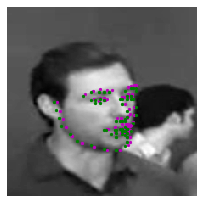

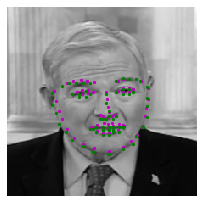

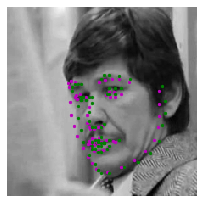

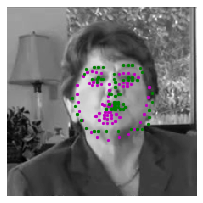

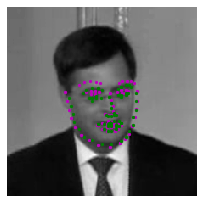

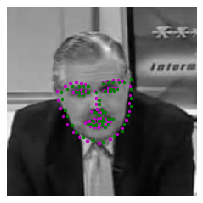

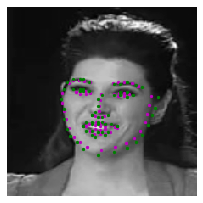

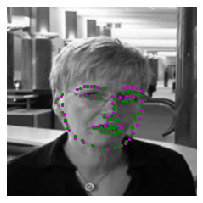

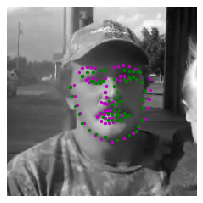

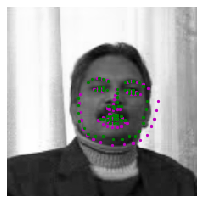

In [18]:

#visualize_output(train_images, train_outputs, gt_pts)
visualize_output(test_images, test_outputs, gt_pts)

[[-0.32979256 -0.02539444  0.04081633]
 [ 0.19456396  0.03197908 -0.06316237]
 [-0.29450664  0.10670155  0.02851407]]
(3, 3)


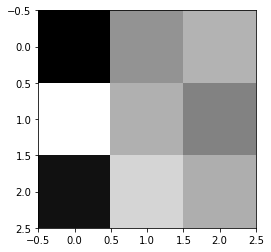

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


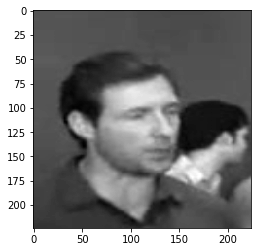

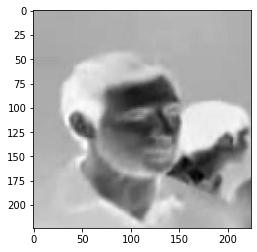

In [20]:
import cv2
# un-transform the image data
image = test_images[0].data   # get the image from it's Variable wrapper
image = image.cpu().numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image = np.squeeze(image)
plt.imshow(image,cmap='gray')
imageF = cv2.filter2D(image, -1, w[filter_index][0])
plt.figure()
plt.imshow(imageF,cmap='gray')

In [0]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    #for data in train_loader:
    for batch_i, data in enumerate(train_loader):
      # get the input images and their corresponding labels
      images = data['image']
      key_pts = data['keypoints']

      # flatten pts
      key_pts = key_pts.view(key_pts.size(0), -1)

      # convert variables to floats for regression loss
      key_pts = key_pts.type(torch.cuda.FloatTensor)
      images = images.type(torch.cuda.FloatTensor)

      batch_num += 1
      #inputs, targets = data
      #inputs = inputs.to(device)
      #targets = targets.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = loss_fn(outputs, key_pts)

      # Crash out if loss explodes

      if batch_num > 1 and loss > 4 * best_loss:
        if(len(log_lrs) > 20):
          return log_lrs[10:-5], losses[10:-5]
        else:
          return log_lrs, losses

        # Record the best loss

      if loss < best_loss or batch_num == 1:
        best_loss = loss

      # Store the values
      losses.append(loss.item())
      log_lrs.append((lr))

        # Do the backward pass and optimize

      loss.backward()
      optimizer.step()

        # Update the lr for the next step and store

      lr *= update_step
      optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [0]:
(lrs, losses) = find_lr(net, criterion,optimizer, train_loader,device=device)

/content/drive/My Drive/FaceDetection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


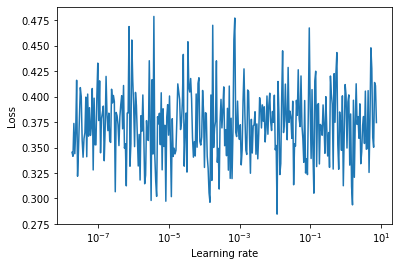

In [0]:
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()